In [3]:
import pandas as pd 
bank = pd.read_csv("bank.csv",sep=';')
bank_full = pd.read_csv("bank-full.csv" , sep=';')
print(bank)
print(bank_full)

for df in [bank,bank_full]:
    if 'duration ' in df.columns:
        df.drop('duration', axis=1, inplace= True)

print("bank.csv(basic 10%):",bank.shape)
print("bank-full.csv (basic 100%):",bank_full.shape)

      age            job  marital  education default  balance housing loan  \
0      30     unemployed  married    primary      no     1787      no   no   
1      33       services  married  secondary      no     4789     yes  yes   
2      35     management   single   tertiary      no     1350     yes   no   
3      30     management  married   tertiary      no     1476     yes  yes   
4      59    blue-collar  married  secondary      no        0     yes   no   
...   ...            ...      ...        ...     ...      ...     ...  ...   
4516   33       services  married  secondary      no     -333     yes   no   
4517   57  self-employed  married   tertiary     yes    -3313     yes  yes   
4518   57     technician  married  secondary      no      295      no   no   
4519   28    blue-collar  married  secondary      no     1137      no   no   
4520   44   entrepreneur   single   tertiary      no     1136     yes  yes   

       contact  day month  duration  campaign  pdays  previous 

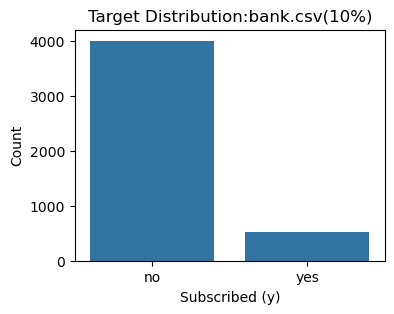

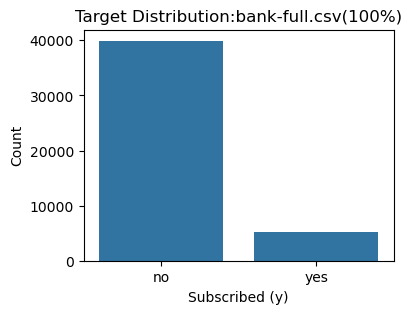

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plot_target_distribution(df,title):
    plt.figure(figsize=(4,3))
    sns.countplot(x="y",data=df)
    plt.title(f"Target Distribution:{title}")
    plt.xlabel("Subscribed (y)")
    plt.ylabel("Count")
    plt.show()
plot_target_distribution(bank,"bank.csv(10%)")
plot_target_distribution(bank_full,"bank-full.csv(100%)")

In [7]:
def check_unknowns(df,name):
    print(f"\n{name}")
    for col in df.columns:
        if df[col].dtype=='object':
            unknown_count= df[col].value_counts().get("unknown",0)
            if unknown_count>0:
                print(f"{col}:{unknown_count} unknowns")

check_unknowns(bank,"bank.csv")
check_unknowns(bank_full,"bank-full.csv")



bank.csv
job:38 unknowns
education:187 unknowns
contact:1324 unknowns
poutcome:3705 unknowns

bank-full.csv
job:288 unknowns
education:1857 unknowns
contact:13020 unknowns
poutcome:36959 unknowns


In [9]:
from sklearn.preprocessing import LabelEncoder

def preprocess_bank_dataset(df):
    df_copy = df.copy()
    label_encoders = {}

    # Encode all object (categorical) columns
    for col in df_copy.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df_copy[col] = le.fit_transform(df_copy[col])
        label_encoders[col] = le

    # Split features and target
    X = df_copy.drop("y", axis=1)
    y = df_copy["y"]

    return X, y, label_encoders


In [11]:
import pandas as pd
bank_df=pd.read_csv("bank.csv",sep=";").drop(columns=['duration'])
bank_full_df =pd.read_csv("bank-full.csv",sep=';').drop(columns=['duration'])
X_bank,y_bank,enc_bank=preprocess_bank_dataset(bank_df)
X_bank_full, y_bank_full,enc_bank_full= preprocess_bank_dataset(bank_full_df)

In [13]:
from sklearn.model_selection import train_test_split

Xb_train, Xb_test, yb_train, yb_test= train_test_split(X_bank, y_bank, test_size=0.2, random_state=42)
Xbf_train, Xbf_test,ybf_train, ybf_test= train_test_split(X_bank_full, y_bank_full, test_size=0.2,random_state=42)

In [15]:
from sklearn.tree import DecisionTreeClassifier

clf_small =DecisionTreeClassifier(max_depth = 5, random_state = 42)
clf_small.fit(Xb_train,yb_train)

clf_full =DecisionTreeClassifier(max_depth = 5 ,  random_state = 42)
clf_full.fit(Xbf_train,ybf_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(clf,X_test, y_test,title='Model'):
    print("\n {title}")
    y_pred=clf.predict(X_test)
    print(" Accuracy:", accuracy_score(y_test,y_pred))
evaluate_model(clf_small, Xb_test,yb_test,"Decision Tree on bank.csv(10%) ")
evaluate_model(clf_full, Xbf_test, ybf_test, "Decision Tree on bank-full.csv(100%")




 {title}
 Accuracy: 0.8928176795580111

 {title}
 Accuracy: 0.8909653875926131


In [19]:
 from sklearn.model_selection import GridSearchCV
param_grid={
    'max_depth':[2,5,10,15],
    'min_samples_split':[2,5,10],
    'criterion':['gini','entropy']
}
clf_base= DecisionTreeClassifier(random_state=42)

grid_search =GridSearchCV(estimator=clf_base, param_grid= param_grid,cv=5,scoring='accuracy',verbose=1,n_jobs=-1)
grid_search.fit(Xbf_train,ybf_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [20]:
print(" Vest Paramerets Found:")
print(grid_search.best_params_)

 Vest Paramerets Found:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


In [21]:
evaluate_model(grid_search.best_estimator_,Xbf_test,ybf_test, "Tuned Decision Tree on bank-full.csv")


 {title}
 Accuracy: 0.8896383943381622


In [22]:
cv_results= pd.DataFrame(grid_search.cv_results_)
cv_results= cv_results.sort_values(by='mean_test_score', ascending=False)

print("\n Top 5 cv Results")
print(cv_results[['mean_test_score','params']].head())


 Top 5 cv Results
    mean_test_score                                             params
17         0.892363  {'criterion': 'entropy', 'max_depth': 5, 'min_...
16         0.892363  {'criterion': 'entropy', 'max_depth': 5, 'min_...
15         0.892363  {'criterion': 'entropy', 'max_depth': 5, 'min_...
5          0.891562  {'criterion': 'gini', 'max_depth': 5, 'min_sam...
3          0.891534  {'criterion': 'gini', 'max_depth': 5, 'min_sam...


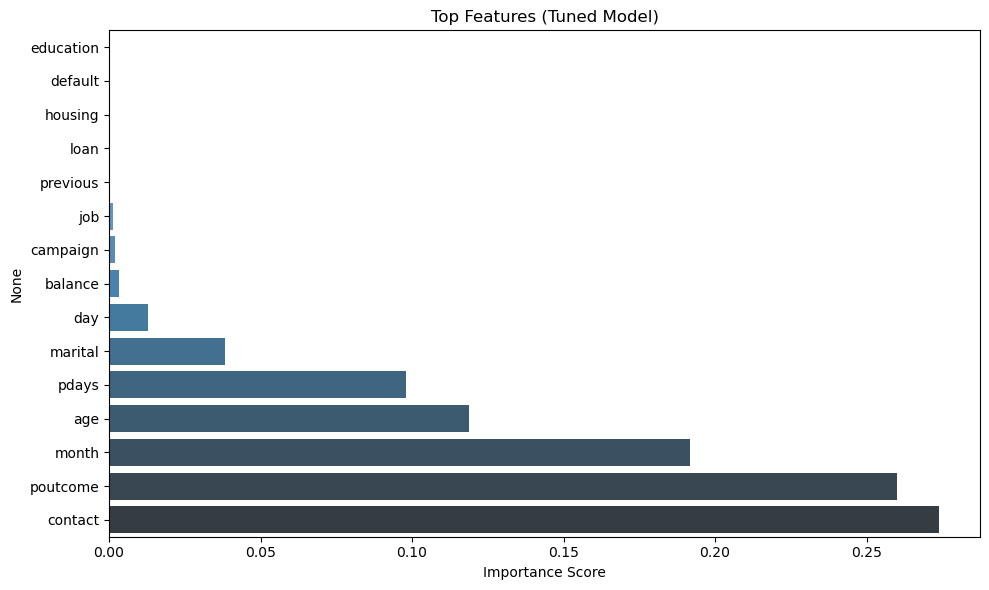

In [40]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, feature_names, title="Feature Importance"):
    # Get importance scores
    importance = model.feature_importances_
    fi_df = pd.Series(importance, index=feature_names).sort_values(ascending=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_df.values, y=fi_df.index, hue=fi_df.index, palette="Blues_d", legend=False)
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Example usage
best_model = grid_search.best_estimator_
plot_feature_importance(best_model, Xbf_train.columns, "Top Features (Tuned Model)")


<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

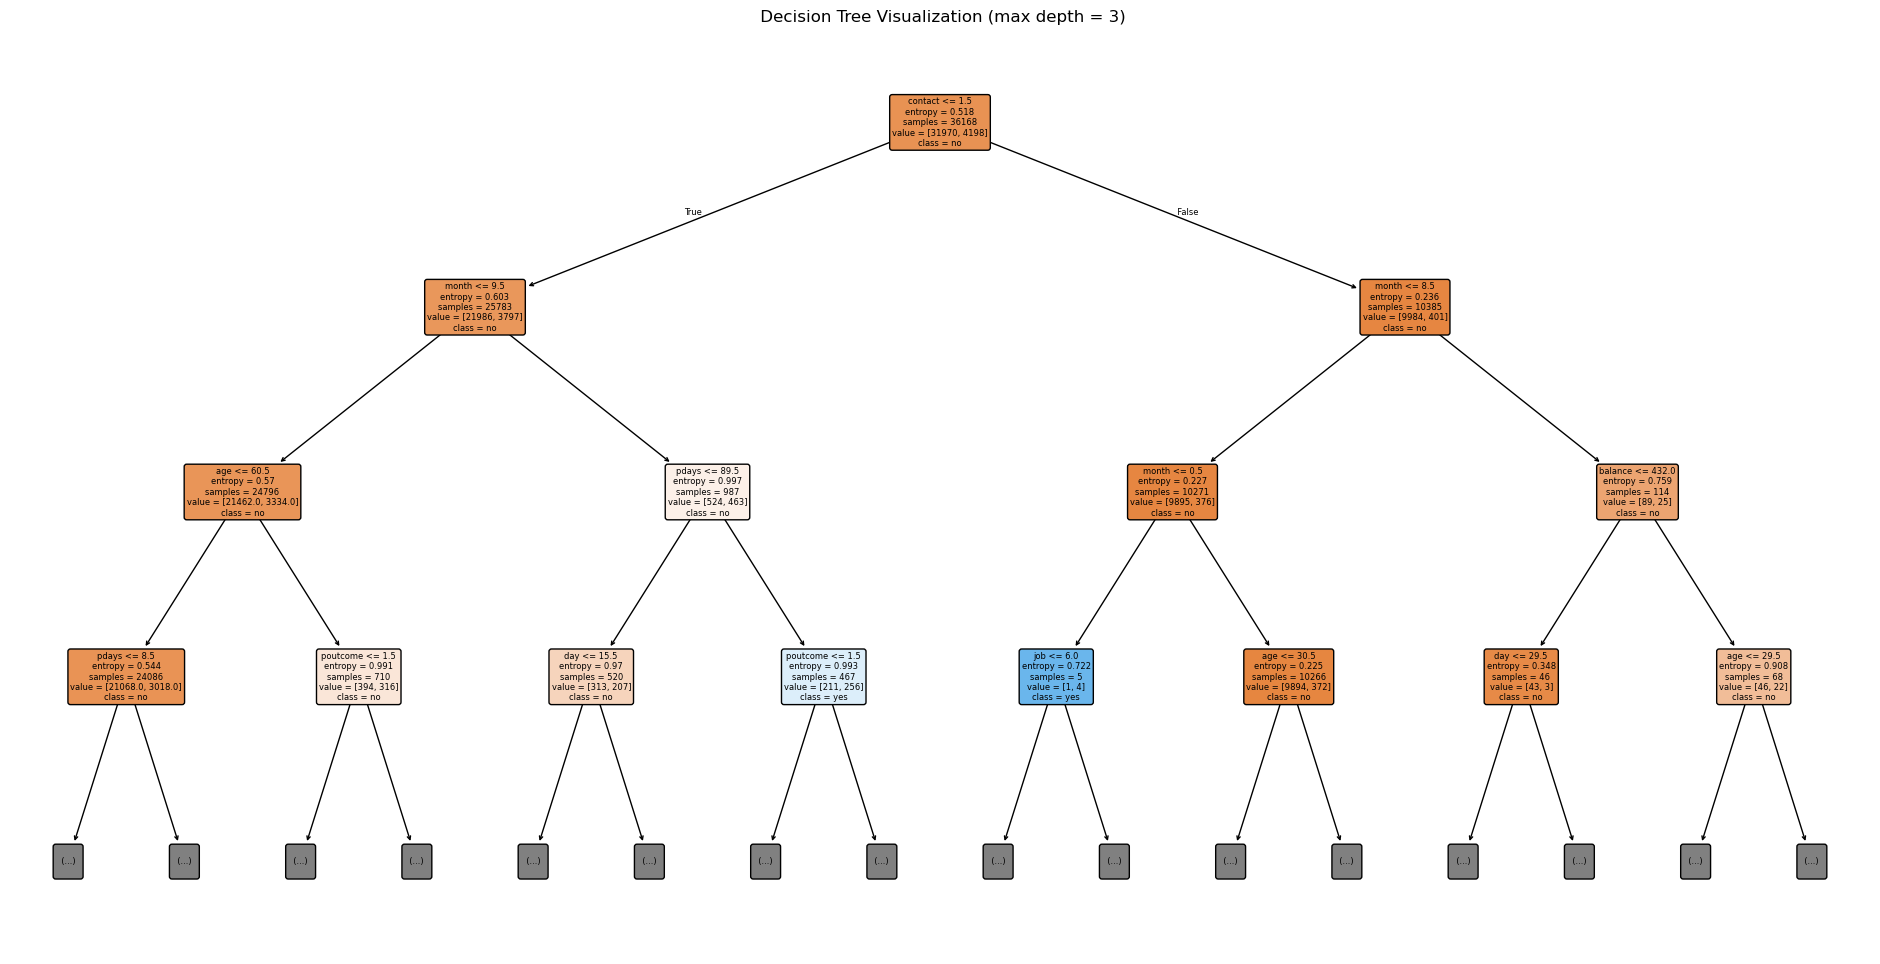

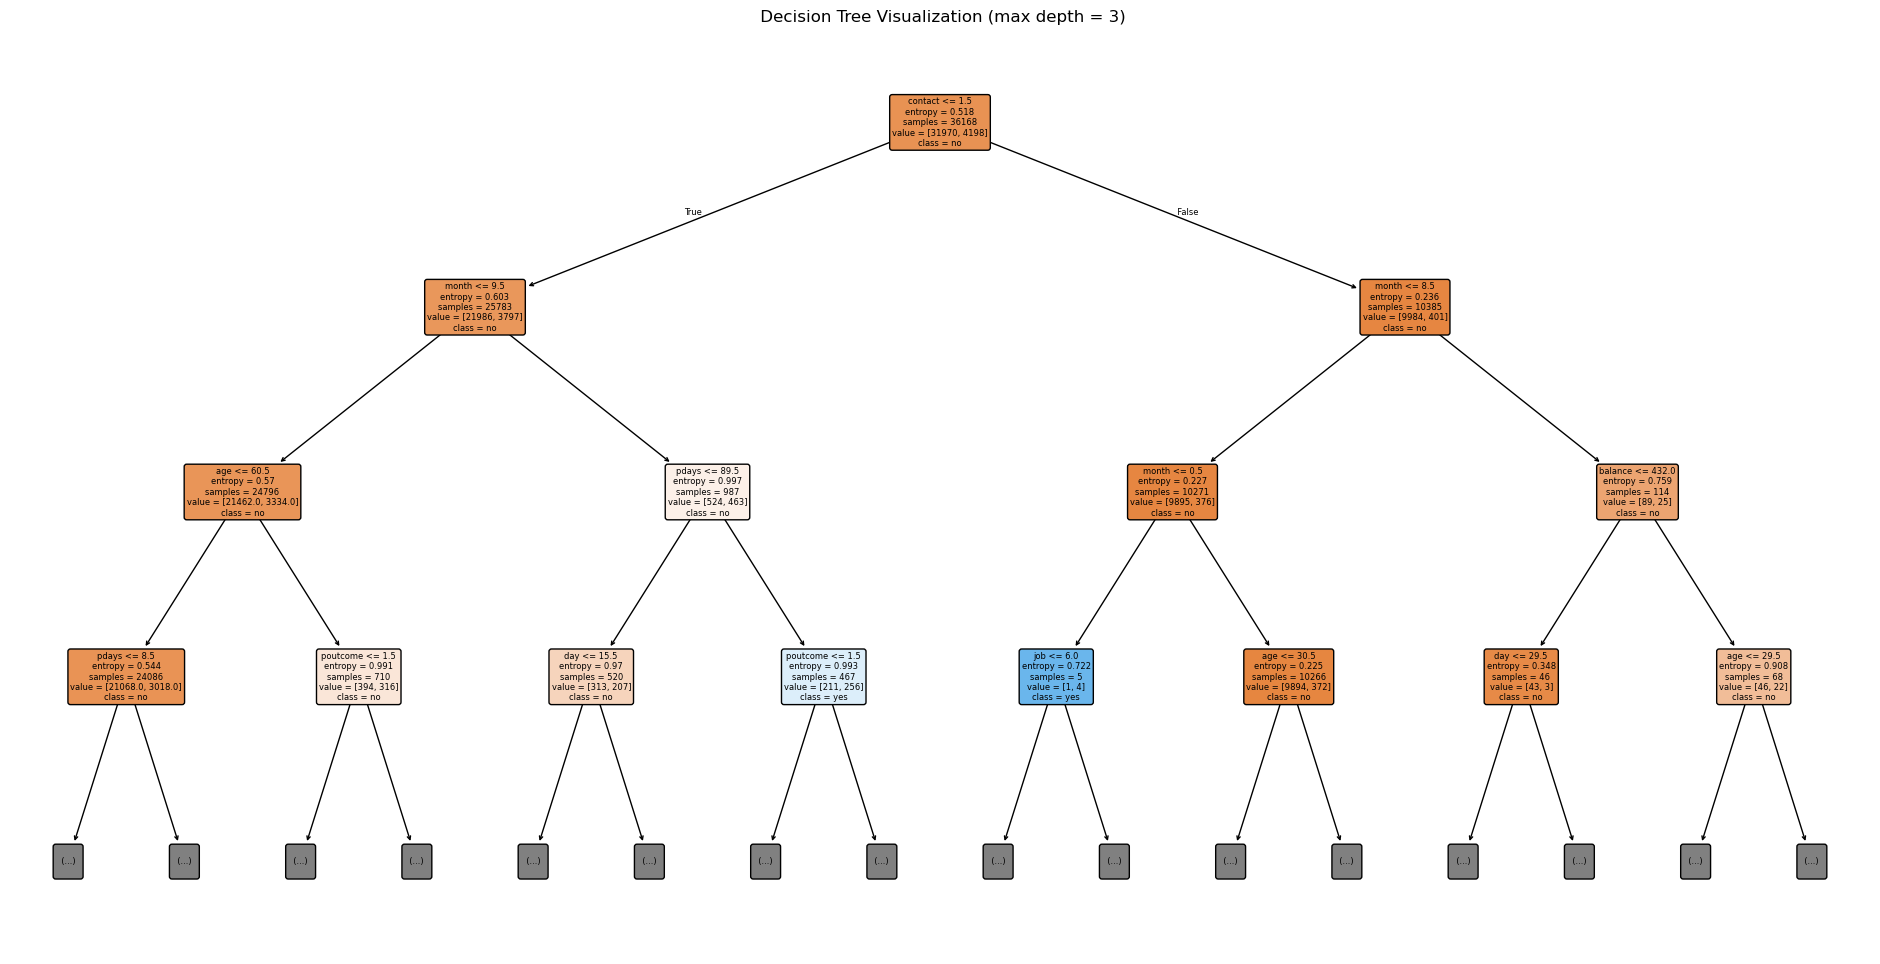

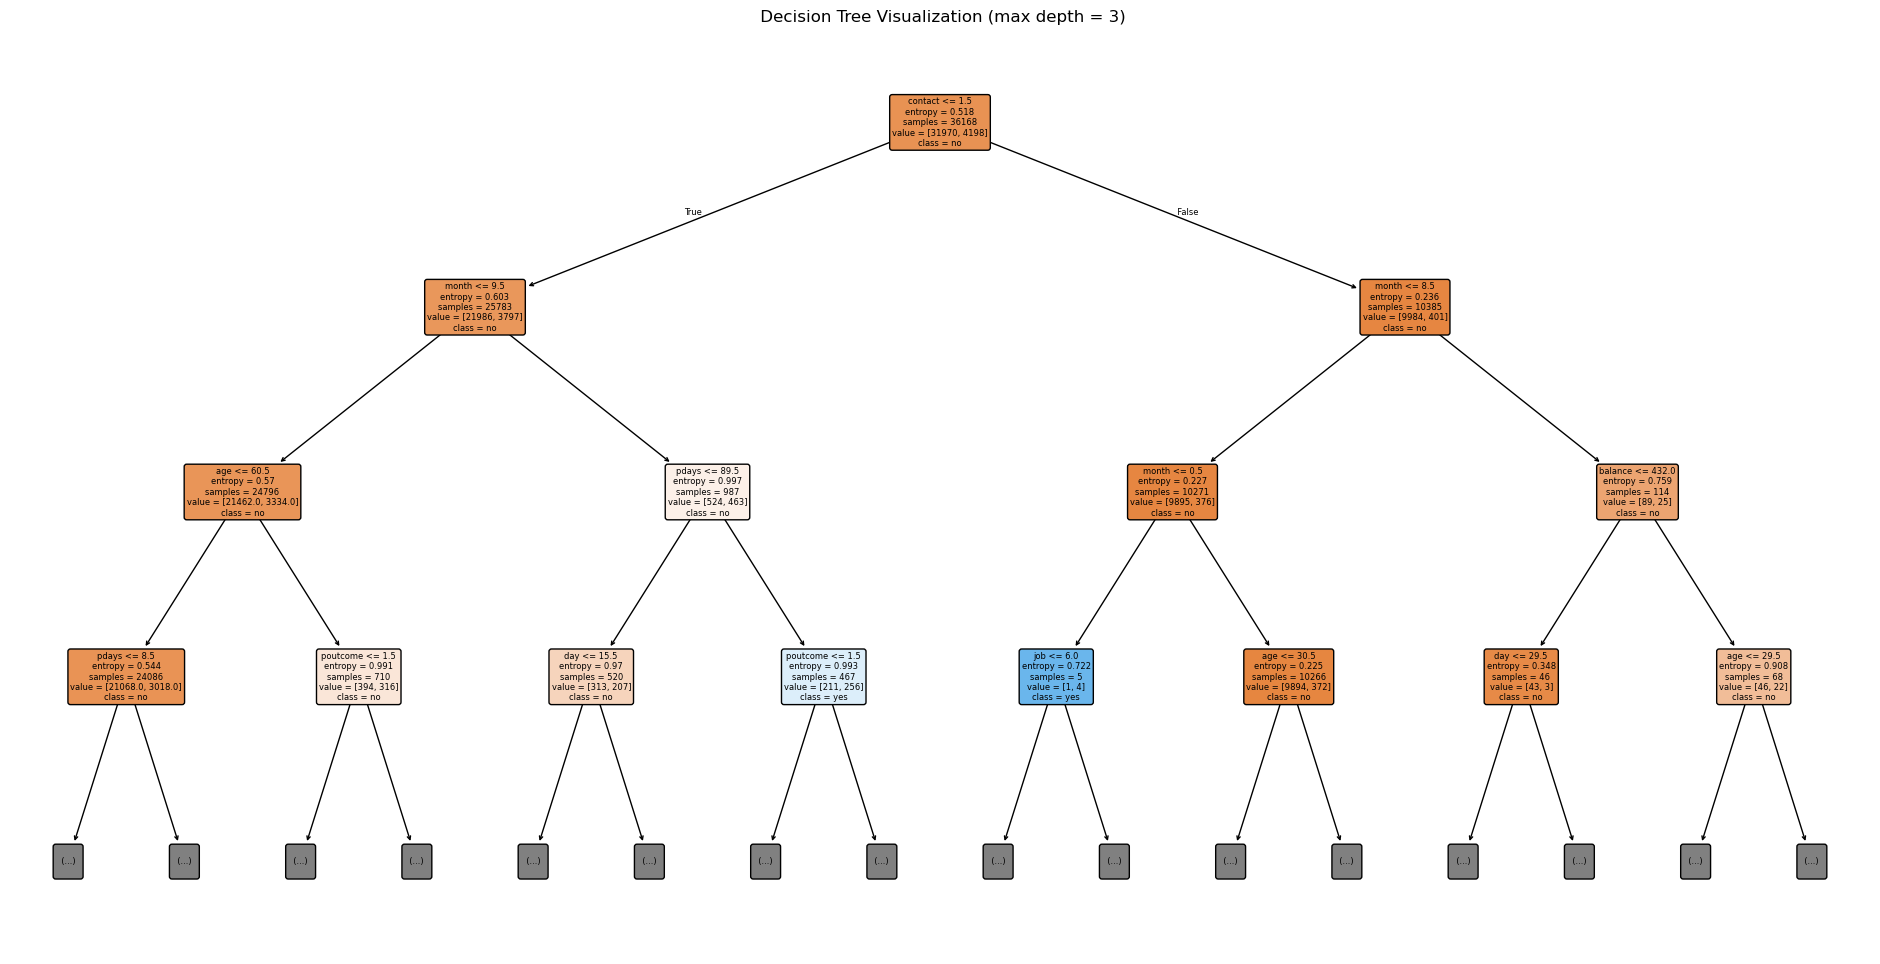

In [52]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24,12))
plot_tree(best_model,
         feature_names=Xbf_train.columns,
         class_names=enc_bank_full['y'].classes_,
         filled=True,
         rounded=True,
         max_depth=3,
         )
plt.title(" Decision Tree Visualization (max depth = 3)")
plt.show()

In [58]:
{
    'age': 45,
    'job':'admin',
    'marital':'married',
    'education':'secondary',
    'default':'no',
    'balance':1000,
    'housing':'yes',
    'loan':'no',
    'contact':'cellular',
    'day':5,
    'month':'may',
    'campaign':1,
    'pdays':-1,
    'previous':0,
    'poutcome':'unknown'
}

{'age': 45,
 'job': 'admin',
 'marital': 'married',
 'education': 'secondary',
 'default': 'no',
 'balance': 1000,
 'housing': 'yes',
 'loan': 'no',
 'contact': 'cellular',
 'day': 5,
 'month': 'may',
 'campaign': 1,
 'pdays': -1,
 'previous': 0,
 'poutcome': 'unknown'}

In [65]:
# Define the values for testing
poutcome = "unknown"
age = 40
housing = "yes"

# Decision logic
if poutcome == "unknown":
    # go left
    if age > 35:
        # go right
        if housing == "yes":
            prediction = "no"
        else:
            prediction = "yes"
    else:
        prediction = "yes"
else:
    prediction = "yes"  # or another outcome for known poutcome

print("Predicted y:", prediction)


Predicted y: no


In [67]:
import joblib
joblib.dump(best_model,"tuned_decision_tree_model.pkl")

['tuned_decision_tree_model.pkl']

In [72]:
loaded_model=joblib.load("tuned_decision_tree_model.pkl")

In [76]:
def predict_user(input_dict, model, encoders):
    input_df = pd.DataFrame([input_dict])

    for col in input_df.columns:
        if col in encoders:
            le = encoders[col]
            if input_df[col].iloc[0] not in le.classes_:
                # Handle unknown labels by assigning the first known class
                input_df[col] = le.transform([le.classes_[0]])
            else:
                input_df[col] = le.transform(input_df[col])

    prediction = model.predict(input_df)[0]
    prob = model.predict_proba(input_df).max()

    # Inverse transform the encoded target to get the original label
    predicted_label = encoders["y"].inverse_transform([prediction])[0]

    return predicted_label, round(prob, 3)


In [84]:
# Example input (same feature names as in bank.csv)
sample_input = {
    'age': 35,
    'job': 'admin.',
    'marital': 'single',
    'education': 'secondary',
    'default': 'no',
    'balance': 1000,
    'housing': 'no',
    'loan': 'no',
    'contact': 'cellular',
    'day': 5,
    'month': 'may',
    'campaign': 1,
    'pdays': -1,
    'previous': 0,
    'poutcome': 'unknown'
}

# Make prediction
pred, prob = predict_user(sample_input, best_model, enc_bank_full)
print("Prediction:", pred)
print("Confidence:", prob)

Prediction: no
Confidence: 0.854
